## Leitura dos dados

* Leitura dos dados do INMET para a estação de porto alegre, coordenadas -30.05, -51.16. 
* Há diversos dados metereológicos nesse banco, entre eles temperatura, pressão, velocidade e direção do vento. 
     * Está análise utiliza apenas os dados de velocidade do vento. 
* Os dados são fornecidos de 6 em 6 horas e foram coletados desde 1962 até 2019. 
* O código abaixo faz a leitura dos dados e exibe as últimas linhas da série, após um pouco de data wrangling.
* Após os dados são exibidos os tipos de cada coluna que indica que os dados foram convertidos adequadamente
* Dados coletados em UTC 0 convertidos em UTC -3
* TODO:
    * Coletar esses dados via código usando BeautifulSoup ou algo similar
    * Concatenar todas as torres do banco do INMET (multiprocessing, pd.concat)

In [3]:
from pathlib import Path
import pandas as pd
path = Path(r'/home/diogo/Jupyter/tdef/inmet_portoalegre.txt')
df = pd.read_table(path, skiprows=47, skipfooter=1, engine='python', sep=';', index_col=False, parse_dates=[[1,2]], dayfirst=True) \
       .rename(columns={'VelocidadeVentoNebulosidade':'VelocidadeVento', 'Unnamed: 9':'Nebulosidade'}) \
       .set_index('Data_Hora').shift(freq=pd.DateOffset(hours=-3))
display(df.tail())
df.dtypes

,Estacao,TempBulboSeco,TempBulboUmido,UmidadeRelativa,PressaoAtmEstacao,DirecaoVento,VelocidadeVento,Nebulosidade
Data_Hora,,,,,,,,
2019-02-28 09:00:00,83967,21.0,NaN,82.0,1009.4,0.0,0.00000,4.00
2019-02-28 15:00:00,83967,28.2,NaN,51.0,1010.0,27.0,3.00000,3.00
2019-02-28 21:00:00,83967,22.4,NaN,68.0,1009.2,14.0,1.00000,0.00
2019-03-01 09:00:00,83967,22.7,NaN,75.0,1010.4,0.0,0.00000,1.25
2019-03-01 15:00:00,83967,31.3,NaN,43.0,1006.7,32.0,1.02888,3.75


Estacao                int64
TempBulboSeco        float64
TempBulboUmido       float64
UmidadeRelativa      float64
PressaoAtmEstacao    float64
DirecaoVento         float64
VelocidadeVento      float64
Nebulosidade         float64
dtype: object

## Visualização dos dados

* Plotando alguns anos de dados é pode-se familiarizar-se com a "cara" dos dados e já perceber algum comportamento cíclico.

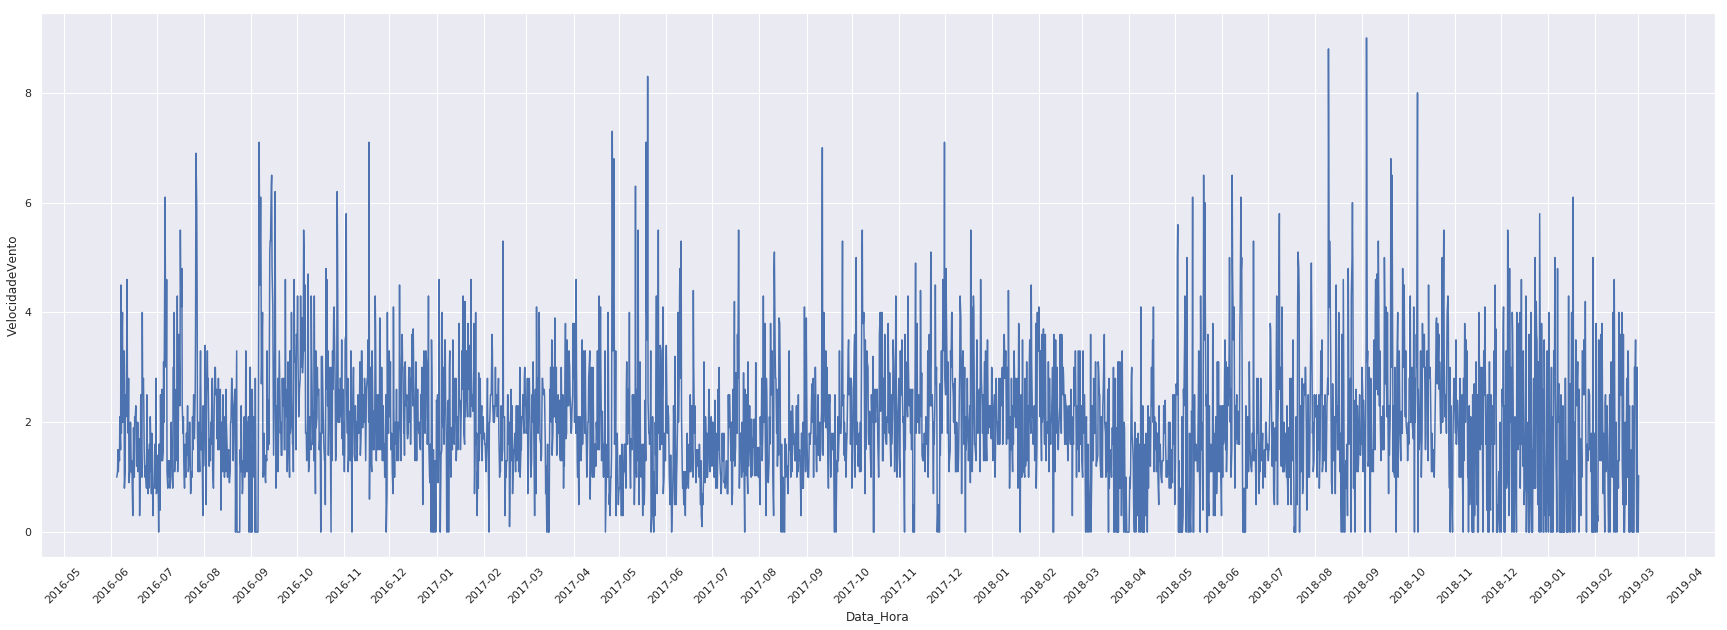

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt, matplotlib.dates as dates, seaborn as sb; sb.set()

def lineplot(data, x=None, y=None):
    _, ax = plt.subplots(figsize=(30,10))
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))
    sb.lineplot(data=data, x=x, y=y)
    plt.xticks(rotation=45);
    
lineplot(data=df.reset_index().tail(3000), x='Data_Hora', y='VelocidadeVento')

## Variância

* Deseja-se saber o comportamento da variância da série de modo a optar por um modelo de previsão adequado
* Os resultados mostram que há "variação da variância" tanto pra mais quanto pra menos não importando:
    * O tamanho da janela (anual, mensal)
    * A tentativa de tornar a série estacionário por meio de retornos logaritimos
    * TODO: explorar diferentes tipos de janelas (Hahn, Hamming, Parzen, ...)
* Tal conclusão leva a crer que duas caminhos podem ser tomados:
    * Pode-se tentar alguma outra estratégia de tornar a série estacionária (Box-Cox power transform)
    * Pode utilizar um modelo de previsão que dê conta dessa variação condicional  da variância: GARCH

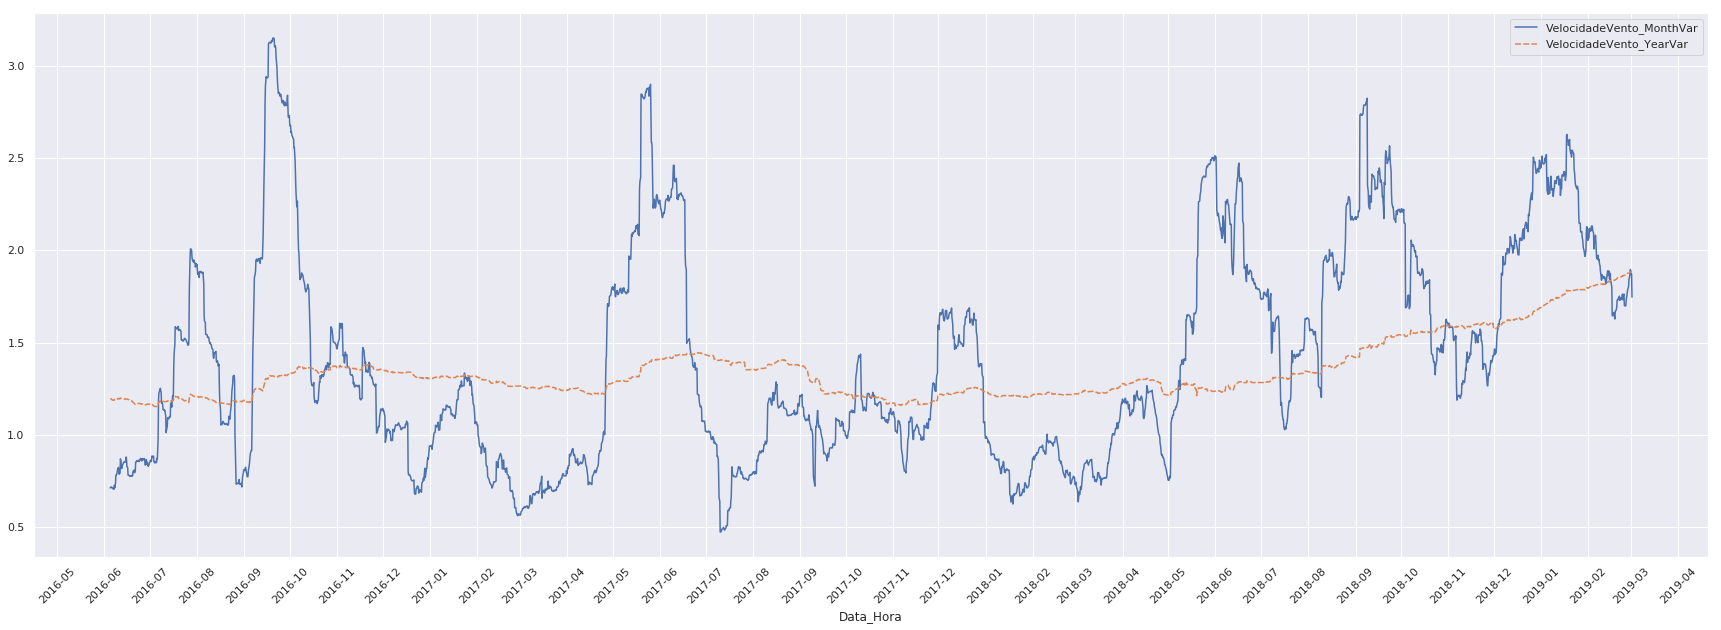

In [5]:
import numpy as np
df['VelocidadeVento_MonthVar'] = df.VelocidadeVento.rolling('30D').var()
df['VelocidadeVento_YearVar'] = df.VelocidadeVento.rolling('365D').var()
lineplot(data=df[['VelocidadeVento_MonthVar', 'VelocidadeVento_YearVar']].tail(3000))

/home/diogo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


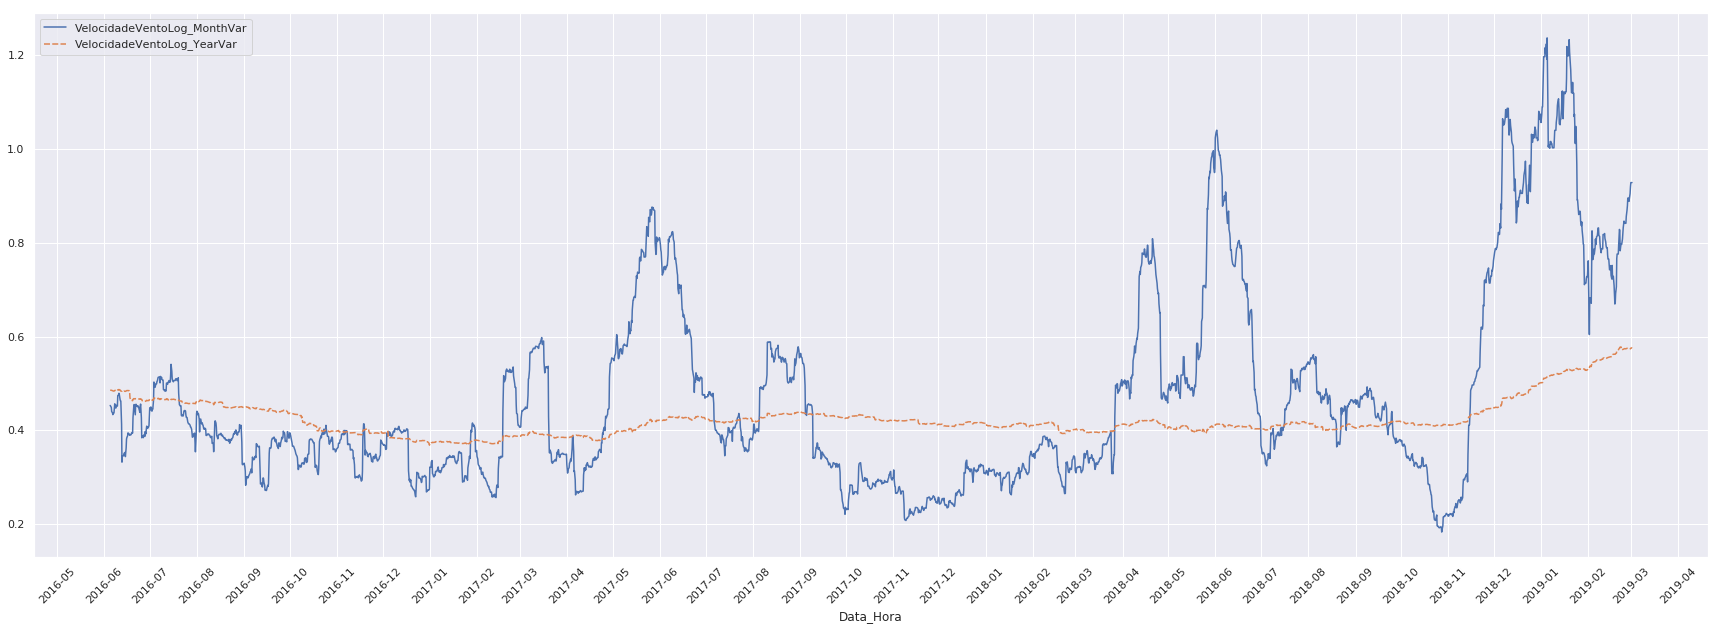

In [6]:
df['VelocidadeVentoLog'] = np.log(df.VelocidadeVento/df.VelocidadeVento.shift())
df['VelocidadeVentoLog_MonthVar'] = df.VelocidadeVentoLog.rolling('30D').var()
df['VelocidadeVentoLog_YearVar'] = df.VelocidadeVentoLog.rolling('365D').var()
lineplot(data=df[['VelocidadeVentoLog_MonthVar', 'VelocidadeVentoLog_YearVar']].tail(3000))
#TODO: explore a Box-Cox transform

# LSTM

In [124]:
N = 1260*4
n = 30*4
g = 60
df_training_complete = df.copy().iloc[-(N+n):-n,:]
df_training_processed = df_training_complete.iloc[:,6:7].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df_training_scaled = scaler.fit_transform(df_training_processed)
features_set = []
labels = []
for i in range(g,N):
    features_set.append(df_training_scaled[i-g:i, 0])
    labels.append(df_training_scaled[i,0])
features_set, labels = np.array(features_set), np.array(labels)
s = features_set.shape
features_set = np.reshape(features_set, (s[0], s[1], 1)) #rows, set_size, predicting
#!pip install tensorflow, keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(features_set, labels, epochs=100, batch_size=32)

Epoch 1/100
4980/4980 [==============================] - 34s 7ms/step - loss: 0.0088
Epoch 2/100
4980/4980 [==============================] - 28s 6ms/step - loss: 0.0081
Epoch 3/100
4980/4980 [==============================] - 28s 6ms/step - loss: 0.0081
Epoch 4/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0080
Epoch 5/100
4980/4980 [==============================] - 31s 6ms/step - loss: 0.0079
Epoch 6/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0078
Epoch 7/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0076
Epoch 8/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0075
Epoch 9/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0074
Epoch 10/100
4980/4980 [==============================] - 29s 6ms/step - loss: 0.0074
Epoch 11/100
4980/4980 [==============================] - 31s 6ms/step - loss: 0.0073
Epoch 12/100
4980/4980 [==============================] - 27s 5

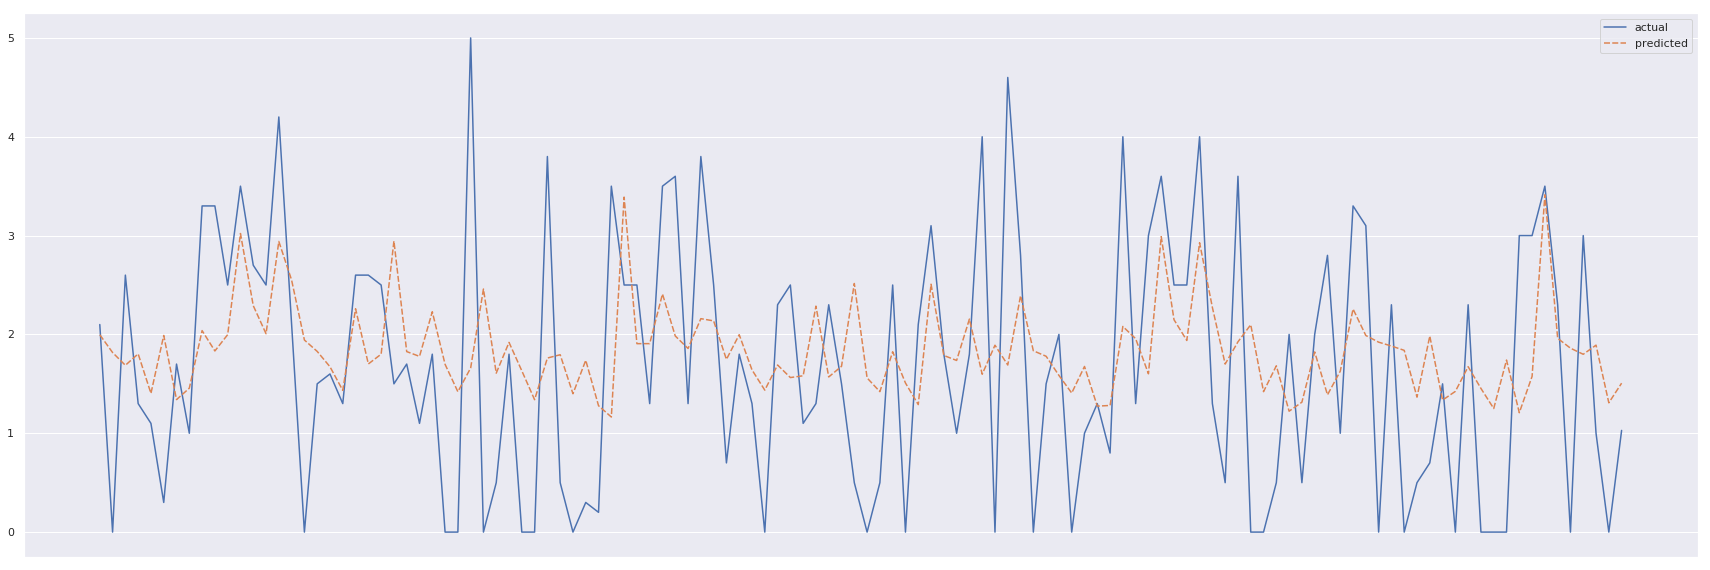

In [125]:
df_testing_complete = df.copy().iloc[-n:,:]
df_testing_processed = df_testing_complete.iloc[:,6:7].values
df_total = pd.concat([df_training_complete['VelocidadeVento'], df_testing_complete['VelocidadeVento']],axis=0)
test_inputs = df_total[len(df_total)-len(df_testing_complete)-60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
test_features = []
for i in range(g, g+n):
    test_features.append(test_inputs[i-g:i, 0])
test_features = np.array(test_features)
s = test_features.shape
test_features = np.reshape(test_features, (s[0], s[1], 1))
predictions = model.predict(test_features)
predictions = scaler.inverse_transform(predictions)
rdf = pd.DataFrame(np.array([df_testing_processed[:,0], predictions[:,0]]).T, columns=['actual', 'predicted'])
lineplot(data=rdf)
plt.savefig(Path('.') / 'images/lstm.png')
#statsmodels.tsa.statespace.sarimax.SARIMAX

In [67]:
#fatos estilizados para ativos financeiros
from multiprocessing import Pool
from scipy import signal
from functools import partial

def windowed_variance(series, window_type, window_size=2):
    #s = series.rolling(window_size).apply(lambda x: (series[x]*getattr(signal, window_type)(window_size)).var(), raw=False)
    #(x.values*getattr(signal, window_type)(window_size)).var()
    s = series.rolling(window_size).apply(lambda x: print(x), raw=False)
    s.name += '_'+window_type
    return s
window_types = ['bartlett','blackman']#,'boxcar','cosine','hamming','hann','parzen','triang']
dfs = Pool(4).map(partial(windowed_variance, df.VelocidadeVento.tail(10)), window_types)
cdf = pd.concat([df.VelocidadeVento.tail(10), pd.concat(dfs, axis=1)], axis=1)
lineplot(data=cdf.reset_index())

Data_Hora
2019-02-26 15:00:00    0.0
2019-02-26 21:00:00    3.0
dtype: float64Data_Hora
2019-02-26 15:00:00    0.0
2019-02-26 21:00:00    3.0
dtype: float64



TypeError: must be real number, not NoneType

## SARIMA
* Um modelo GARCH presume que a série de entrada não possui comportamento cíclico, desta forma deve-se removê-lo da série.
* TODO: 
    * evidenciar que dados de vento possuem comportamento cíclico diário, semanal, mensal, sazonal, anual ...
        * Pode-se utilizar uma fft pra evidenciar isso também?
    * mostrar que a previsão com AR é falha (chegar nos coeficientes tanto por PACF plot quanto por grid_search)
    * mostrar que a previsão com MA é falha (chegar nos coeficientes tanto por ACF plot quanto por grid_search)
    * mostrar que a previsão com ARMA é falha
    * mostrar que a previsão com ARIMA é falha

In [300]:
#TODO: learn how to apply different window functions:
import scipy as sp

def window_single_sided_parzen(window_size):
    return sp.signal.parzen((window_size-1)*2+1)[0:window_size]

def custom_rolling_sum(x, window):
    return (x * window).var()

size_win = 1000
dfz = pd.DataFrame(np.random.randint(0,100,size=(10000, 4)), columns=list('ABCD'))
dfz.rolling(window=size_win).apply(lambda x: custom_rolling_sum(x, window_single_sided_parzen(size_win))).head()

# barthann(M[, sym]) 	Return a modified Bartlett-Hann window.
# bartlett(M[, sym]) 	Return a Bartlett window.
# blackman(M[, sym]) 	Return a Blackman window.
# blackmanharris(M[, sym]) 	Return a minimum 4-term Blackman-Harris window.
# bohman(M[, sym]) 	Return a Bohman window.
# boxcar(M[, sym]) 	Return a boxcar or rectangular window.
# chebwin(M, at[, sym]) 	Return a Dolph-Chebyshev window.
# cosine(M[, sym]) 	Return a window with a simple cosine shape.
# exponential(M[, center, tau, sym]) 	Return an exponential (or Poisson) window.
# flattop(M[, sym]) 	Return a flat top window.
# gaussian(M, std[, sym]) 	Return a Gaussian window.
# general_gaussian(M, p, sig[, sym]) 	Return a window with a generalized Gaussian shape.
# hamming(M[, sym]) 	Return a Hamming window.
# hann(M[, sym]) 	Return a Hann window.
# hanning(M[, sym]) 	Return a Hann window.
# kaiser(M, beta[, sym]) 	Return a Kaiser window.
# nuttall(M[, sym]) 	Return a minimum 4-term Blackman-Harris window according to Nuttall.
# parzen(M[, sym]) 	Return a Parzen window.
# slepian(M, width[, sym]) 	Return a digital Slepian (DPSS) window.
# triang(M[, sym]) 	Return a triangular window.
# tukey(M[, alpha, sym]) 	Return a Tukey window, also known as a tapered cosine window.

/home/diogo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':


,A,B,C,D
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [ ]:
from math import sqrt
from multiprocessing import cpu_count
#from joblib import Parallel
#from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
from pandas import datetime
from functools import partial
from multiprocessing import Pool, cpu_count
import time

# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error
 
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    tic = time.time()
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
                print(f'it took {time.time()-tic} to run {cfg}')
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        #scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
        fn = partial(score_model, data, n_test)
        print(len(cfg_list))
        scores = Pool(cpu_count()).map(fn, cfg_list)
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores
 
# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [0, 4, 4*7, 4*30, 4*365]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models
 
 
# parse dates
def custom_parser(x):
    return datetime.strptime('195'+x, '%Y-%m')
 
if __name__ == '__main__':
    # load dataset
    series = df.VelocidadeVento#read_csv('shampoo.csv', header=0, index_col=0, date_parser=custom_parser)
    data = series.values[-3000:]
    print(data.shape)
    # data split
    n_test = 4*3
    # model configs
    cfg_list = sarima_configs()
    # grid search
    scores = grid_search(data, cfg_list, n_test, False)
    print('done')
    # list top 3 configs
    for cfg, error in scores:
        print(cfg, error)

(3000,)
6480
it took 3.0642311573028564 to run [(0, 0, 0), (0, 0, 0, 0), 'n']
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 1.971
it took 2.852843999862671 to run [(0, 0, 0), (0, 0, 0, 4), 'n']
 > Model[[(0, 0, 0), (0, 0, 0, 4), 'n']] 1.971
it took 8.135740995407104 to run [(0, 0, 1), (1, 1, 0, 4), 'n']
 > Model[[(0, 0, 1), (1, 1, 0, 4), 'n']] 1.734
it took 2.404841423034668 to run [(0, 0, 0), (0, 0, 0, 28), 'n']
 > Model[[(0, 0, 0), (0, 0, 0, 28), 'n']] 1.971
it took 3.4916069507598877 to run [(0, 0, 0), (0, 0, 0, 120), 'n']
 > Model[[(0, 0, 0), (0, 0, 0, 120), 'n']] 1.971
it took 3.364744186401367 to run [(0, 0, 0), (0, 0, 0, 1460), 'n']
 > Model[[(0, 0, 0), (0, 0, 0, 1460), 'n']] 1.971
it took 18.166887760162354 to run [(0, 1, 0), (1, 1, 0, 4), 'c']
 > Model[[(0, 1, 0), (1, 1, 0, 4), 'c']] 2.198
it took 23.54905652999878 to run [(0, 0, 2), (0, 0, 0, 0), 'c']
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'c']] 1.441
it took 10.645846843719482 to run [(0, 0, 0), (0, 0, 1, 0), 'n']
 > Model[[(0, 0, 0)

/home/diogo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if __name__ == '__main__':


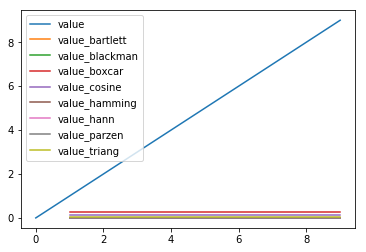

In [9]:
def fn():
    print('x')
fn(None)

TypeError: fn() takes 0 positional arguments but 1 was given